In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
import sklearn.metrics as m 
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from joblib import dump,load

from sklearn.feature_selection import SelectKBest,f_regression


In [2]:
df=pd.read_csv("insurance.csv")
df

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


In [3]:
df.nunique()

age           47
sex            2
bmi          275
children       6
smoker         2
region         4
expenses    1337
dtype: int64

In [4]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [5]:
# expenses is not included as it is dependent column
num_cols=["age","bmi"]
cat_cols=["sex","children","smoker","region"]

In [6]:
num_trans=Pipeline(steps=[
    ("scaler",StandardScaler())
])

cat_trans=Pipeline(steps=[
    ("enccoder",OneHotEncoder(drop="first",handle_unknown="ignore"))
])

processed=ColumnTransformer(transformers=[
    ("numerical",num_trans,num_cols),
    ("categorical",cat_trans,cat_cols)
])

model=Pipeline(steps=[
    ("preprocessor",processed),
    ("selector",SelectKBest(f_regression)),
    ("regressor",RandomForestRegressor())
])

model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi']),
                                                 ('categorical',
                                                  Pipeline(steps=[('enccoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sex', 'children', 'smoker',
                                                   'region'])])),
                ('selector',
                 SelectKBest(score_func=<function f_regression at 0x000001FF712CB940>)),
                ('regressor', RandomForestRegressor())])

In [7]:
x,y=df.drop("expenses",axis=1),df["expenses"]
x,y

(      age     sex   bmi  children smoker     region
 0      19  female  27.9         0    yes  southwest
 1      18    male  33.8         1     no  southeast
 2      28    male  33.0         3     no  southeast
 3      33    male  22.7         0     no  northwest
 4      32    male  28.9         0     no  northwest
 ...   ...     ...   ...       ...    ...        ...
 1333   50    male  31.0         3     no  northwest
 1334   18  female  31.9         0     no  northeast
 1335   18  female  36.9         0     no  southeast
 1336   21  female  25.8         0     no  southwest
 1337   61  female  29.1         0    yes  northwest
 
 [1338 rows x 6 columns],
 0       16884.92
 1        1725.55
 2        4449.46
 3       21984.47
 4        3866.86
           ...   
 1333    10600.55
 1334     2205.98
 1335     1629.83
 1336     2007.95
 1337    29141.36
 Name: expenses, Length: 1338, dtype: float64)

In [8]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=42)

In [9]:
param_grid={
    "selector__k":[2,3,4,5],
    "regressor__max_depth":[10,51,10],
    "regressor__n_estimators":[10,51,10],
    "regressor__criterion":["absolute_error","friedman_mse","poisson","squared_error"]
}

result=GridSearchCV(model,param_grid,n_jobs=-1,verbose=1)
result.fit(xtrain,ytrain)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'bmi']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('enccoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['sex',
                                                                          'children',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('selector',
                                        SelectKBest(score_func=<function f_regression at 0x000001FF712CB940>)),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__criterion': ['absolute_error',
                                                  'friedman_mse', 'poisson',
                                                  'squared_error'],
                         'regressor__max_depth': [10, 51, 10],
                         'regressor__n_estimators': [10, 51, 10],
                         'selector__k': [2, 3, 4, 5]},
             verbose=1)

In [10]:
result.best_params_

{'regressor__criterion': 'absolute_error',
 'regressor__max_depth': 10,
 'regressor__n_estimators': 51,
 'selector__k': 3}

In [11]:
# model.fit(xtrain,ytrain)

In [12]:
print("Metics")
ypred = result.predict(xtest)
print(f'MAE: {m.mean_absolute_error(ytest, ypred):.2f}')
print(f'MSE: {m.mean_squared_error(ytest, ypred):.2f}')
print(f'R2: {m.r2_score(ytest, ypred):.2f}')

Metics
MAE: 2426.59
MSE: 23485564.76
R2: 0.85


In [13]:
print('Decision Tree Regressor')
print(f'Train Score: {result.score(xtrain, ytrain):.2f}')
print(f'Test Score: {result.score(xtest, ytest):.2f} ')

Decision Tree Regressor
Train Score: 0.93
Test Score: 0.85 


<Axes: ylabel='Density'>

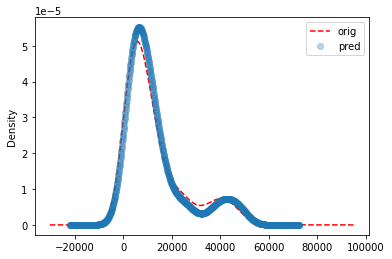

In [14]:
# ytest.values because it is not numpy array
evaldf=pd.DataFrame([ytest.values,ypred],index=["orig","pred"]).T
ax=evaldf.plot(kind="kde",y="orig",style="r--")
evaldf.plot(kind="kde",y="pred",linewidth=10,alpha=.3,style="o",ax=ax)

In [15]:
dump(result,"insurancepredict.jb")

['insurancepredict.jb']

In [16]:
result

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'bmi']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('enccoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['sex',
                                                                          'children',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('selector',
                                        SelectKBest(score_func=<function f_regression at 0x000001FF712CB940>)),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__criterion': ['absolute_error',
                                                  'friedman_mse', 'poisson',
                                                  'squared_error'],
                         'regressor__max_depth': [10, 51, 10],
                         'regressor__n_estimators': [10, 51, 10],
                         'selector__k': [2, 3, 4, 5]},
             verbose=1)